### <span style='color:Blue'> Web Scrapping to get latest NSE Option Chain for Nifty and calculate various spread.
1. The output will be an html page saved in your local drive which will look something like this. 
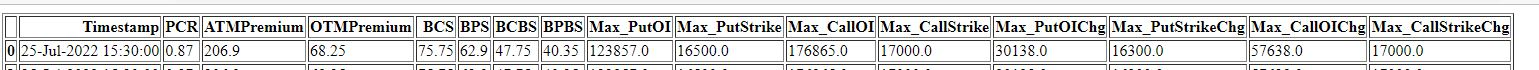
2. There is function set to auto refresh the script every 2 minutes and refresh the HTML page. 

In [1]:
#pip install schedule

I always like to ignore warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import datetime
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import schedule 
import time
from requests.auth import HTTPBasicAuth
import os


User defined input for expiry and range. For instance overhere my objective is to pull the option chan for 16600 + 500 and 16600 -500

In [4]:
ExpiryDate = datetime.datetime(2022,7,28)

ATM = 16600
#Interval = 200

UpRange = ATM + 500
DownRange = ATM - 500


Create an empty dataframe with relevant variables
- PCR - Put Call Ratio
- ATMPremium - At the money premium
- OTMPremium - Out of the money premium
- BCS - Bull Call Spread
- BPS - Bear Put Spread
- BCBS -Bull Call Butterfly Spread
- BPBS - Bear Put Butterfly Spread


In [5]:
Output = pd.DataFrame(columns = ['Timestamp','PCR','ATMPremium','OTMPremium','BCS','BPS','BCBS','BPBS','Max_PutOI','Max_PutStrike','Max_CallOI','Max_CallStrike','Max_PutOIChg','Max_PutStrikeChg','Max_CallOIChg','Max_CallStrikeChg'])

1.We are going to define a function called Option_Chain which takes 3 inputs
- Expiry Date
- UpRange
- Down Range

2.The next step is to extract option chain data using json request and store the results in a dataframe (Options_LargeDataFrame)

3.Subset the OptionsLargeDataframe and create a new dataframe Options_SmallDataFrame.

4.Caclulate the various metrics (PCR, ATMPremium,OTMPremium,etc)/

5.Append the empty dataframe output with the metrics calculated in step 4.

6.Create an HTML file an save it your local drive e.g. 'C:\Users\DX321VW\Downloads\NSEOptionChain.htm'


In [6]:
def Option_Chain(ExpiryDate,UpRange,DownRange):
    while True:
        try:
            url = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'
            headers = {'User-Agent': 'Mozilla/5.0'}
            page = requests.get(url,headers=headers,auth=HTTPBasicAuth('user', 'pass'))
            dajs = page.json()
            Options = dajs['records']['data']
            Timestamp = dajs['records']['timestamp']
            
    #Create Dataframe from JSON requests
            Options_LargeDataFrame = pd.json_normalize(Options)
            Options_LargeDataFrame['expiryDate'] = pd.to_datetime(Options_LargeDataFrame['expiryDate'])
            Options_LargeDataFrame['Timestamp'] = Timestamp
            Options_LargeDataFrame['Timestamp'] = pd.to_datetime(Options_LargeDataFrame['Timestamp'])
            Options_SmallDataFrame =    Options_LargeDataFrame[['strikePrice','expiryDate','PE.openInterest','PE.changeinOpenInterest','PE.lastPrice','PE.impliedVolatility','CE.openInterest','CE.changeinOpenInterest','CE.lastPrice','CE.impliedVolatility','CE.underlyingValue','Timestamp']]
            Options_SmallDataFrame =  Options_SmallDataFrame[(Options_SmallDataFrame['expiryDate'] == ExpiryDate) & (Options_SmallDataFrame['strikePrice'] >= DownRange) & (Options_SmallDataFrame['strikePrice'] <= UpRange) ]
            return(Options_SmallDataFrame)
    #PCR Ratio
            PCR = round(sum(Options_SmallDataFrame['PE.openInterest'])/sum(Options_SmallDataFrame['CE.openInterest']),2)
    
    #Premium and Spreads
            ATMPremium = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'PE.lastPrice'] + 
                       Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'CE.lastPrice'])
    
            OTMPremium = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval,'PE.lastPrice']) + float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval,'CE.lastPrice'])

    
            BCS = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'CE.lastPrice']) - float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval ,'CE.lastPrice'])
            BPS = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'PE.lastPrice']) - float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval ,'PE.lastPrice'])
    
            BCBS = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'CE.lastPrice']) -2*float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval,'CE.lastPrice']) +float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval*2,'CE.lastPrice'])
            BPBS = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'PE.lastPrice']) - 2*float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval,'PE.lastPrice']) + float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval*2,'PE.lastPrice'])
            
            Max_PutOI = max(Options_SmallDataFrame['PE.openInterest'])
            Max_CallOI = max(Options_SmallDataFrame['CE.openInterest'])

            Max_PutOIChg = max(Options_SmallDataFrame['PE.changeinOpenInterest'])
            Max_CallOIChg = max(Options_SmallDataFrame['CE.changeinOpenInterest'])

            Max_PutStrike = float(Options_SmallDataFrame.loc[Options_SmallDataFrame['PE.openInterest'] == Max_PutOI,'strikePrice'])
            Max_CallStrike = float(Options_SmallDataFrame.loc[Options_SmallDataFrame['CE.openInterest'] == Max_CallOI,'strikePrice'])

            Max_PutStrikeChg = float(Options_SmallDataFrame.loc[Options_SmallDataFrame['PE.changeinOpenInterest'] == Max_PutOIChg,'strikePrice'])
            Max_CallStrikeChg = float(Options_SmallDataFrame.loc[Options_SmallDataFrame['CE.changeinOpenInterest'] == Max_CallOIChg,'strikePrice'])
            
    #Append Output to dataframe
            global Output
            Output = Output.append({'Timestamp' : Timestamp, 'PCR' : PCR ,'ATMPremium' : ATMPremium,'OTMPremium' : OTMPremium, 'BCS' : BCS , 'BPS' : BPS ,'BCBS': BCBS,'BPBS' : BPBS,'Max_PutOI':Max_PutOI,'Max_PutStrike':Max_PutStrike,'Max_CallOI':Max_CallOI,'Max_CallStrike':Max_CallStrike,'Max_PutOIChg':Max_PutOIChg,'Max_PutStrikeChg':Max_PutStrikeChg,'Max_CallOIChg':Max_CallOIChg,'Max_CallStrikeChg':Max_CallStrikeChg} , ignore_index = True)
            Output = Output.sort_values(by = ["Timestamp"],ascending = False)
            #Print in the same line
            #with pd.option_context('expand_frame_repr', False):
                #print(Output, end='\r')
            html = Output.to_html()
            text_file = open(r"C:\Users\DX321VW\Downloads\NSEOptionChain.html","w")
            text_file.write(html)
            text_file.close()
          
        except:
            pass
        else:
            break

Using python package schedule to autorun the function every 2 mins.

In [ ]:
schedule.every(2).minutes.do(Option_Chain,ExpiryDate,UpRange,DownRange)

while True:
    schedule.run_pending()
    time.sleep(1)
